### Stock Prediction using fb Prophet

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [8]:
import pandas as pd
import yfinance as yf
import numpy as np
import os 
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from prophet import Prophet


In [9]:
# Define the ticker symbol
ticker_symbol = 'MSFT'

# Fetch the historical data
df_Stock = yf.download(ticker_symbol, start='2004-01-02', progress=False)
Stock_info = yf.Ticker(ticker_symbol).info

# Rename columns
df_Stock = df_Stock.rename(columns={
    'Open': 'Open', 
    'High': 'High', 
    'Low': 'Low', 
    'Close': 'Close', 
    'Volume': 'Volume'
})
df_Stock = df_Stock.rename_axis('Date')

# Sort by date
Stock = df_Stock.sort_index(ascending=True)

# Slice the data for 15 years
Stock = Stock.loc['2004-01-02':]
Stock


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-01-02,27.580000,27.770000,27.330000,27.450001,17.105967,44487700
2004-01-05,27.730000,28.180000,27.719999,28.139999,17.535944,67333700
2004-01-06,28.190001,28.280001,28.070000,28.240000,17.598267,46950800
2004-01-07,28.170000,28.309999,28.010000,28.209999,17.579559,54298200
2004-01-08,28.389999,28.480000,28.000000,28.160000,17.548412,58810800
...,...,...,...,...,...,...
2024-07-23,443.899994,448.390015,443.100006,444.850006,444.850006,13107100
2024-07-24,440.450012,441.480011,427.589996,428.899994,428.899994,26805800
2024-07-25,428.799988,429.799988,417.510010,418.399994,418.399994,29943800


In [10]:
Stock = Stock.drop(columns=['Open', 'High', 'Low', 'Volume'])

In [11]:
Stock.index = pd.to_datetime(Stock.index)

In [12]:
Stock.info()
#NFLX.resample('D').ffill()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5177 entries, 2004-01-02 to 2024-07-29
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close      5177 non-null   float64
 1   Adj Close  5177 non-null   float64
dtypes: float64(2)
memory usage: 121.3 KB


In [13]:
Stock = Stock.reset_index()
Stock

,Date,Close,Adj Close
0,2004-01-02,27.450001,17.105967
1,2004-01-05,28.139999,17.535944
2,2004-01-06,28.240000,17.598267
3,2004-01-07,28.209999,17.579559
4,2004-01-08,28.160000,17.548412
...,...,...,...
5172,2024-07-23,444.850006,444.850006
5173,2024-07-24,428.899994,428.899994
5174,2024-07-25,418.399994,418.399994
5175,2024-07-26,425.269989,425.269989


In [14]:
# Rename columns for Prophet
Stock = Stock.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})

# Initialize Prophet model
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=True)
prophet_model.add_country_holidays(country_name='US')
prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

In [15]:
prophet_model.fit(Stock)

22:17:32 - cmdstanpy - INFO - Chain [1] start processing
22:17:35 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
future = prophet_model.make_future_dataframe(periods=30)
future.tail()

,ds
5202,2024-08-24
5203,2024-08-25
5204,2024-08-26
5205,2024-08-27
5206,2024-08-28


In [17]:
forcast = prophet_model.predict(future)
forcast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
5202,2024-08-24,395.720175,371.563332,417.975885,395.720175,395.720175,0.0,0.0,0.0,0.0,...,0.125296,0.125296,0.125296,0.594930,0.594930,0.594930,0.0,0.0,0.0,395.724390
5203,2024-08-25,395.850762,373.261125,417.494850,395.850762,395.850762,0.0,0.0,0.0,0.0,...,0.125296,0.125296,0.125296,0.601027,0.601027,0.601027,0.0,0.0,0.0,395.512144
5204,2024-08-26,395.981350,372.125533,418.532448,395.981350,395.981350,0.0,0.0,0.0,0.0,...,0.124645,0.124645,0.124645,0.596744,0.596744,0.596744,0.0,0.0,0.0,395.293366
5205,2024-08-27,396.111937,371.991614,416.243604,396.111937,396.111937,0.0,0.0,0.0,0.0,...,-0.106224,-0.106224,-0.106224,0.580718,0.580718,0.580718,0.0,0.0,0.0,395.106586
5206,2024-08-28,396.242524,373.696300,418.296522,396.242524,396.242524,0.0,0.0,0.0,0.0,...,-0.068356,-0.068356,-0.068356,0.551798,0.551798,0.551798,0.0,0.0,0.0,395.459884


c:\Users\ashok\Desktop\SPPO\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\ashok\Desktop\SPPO\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


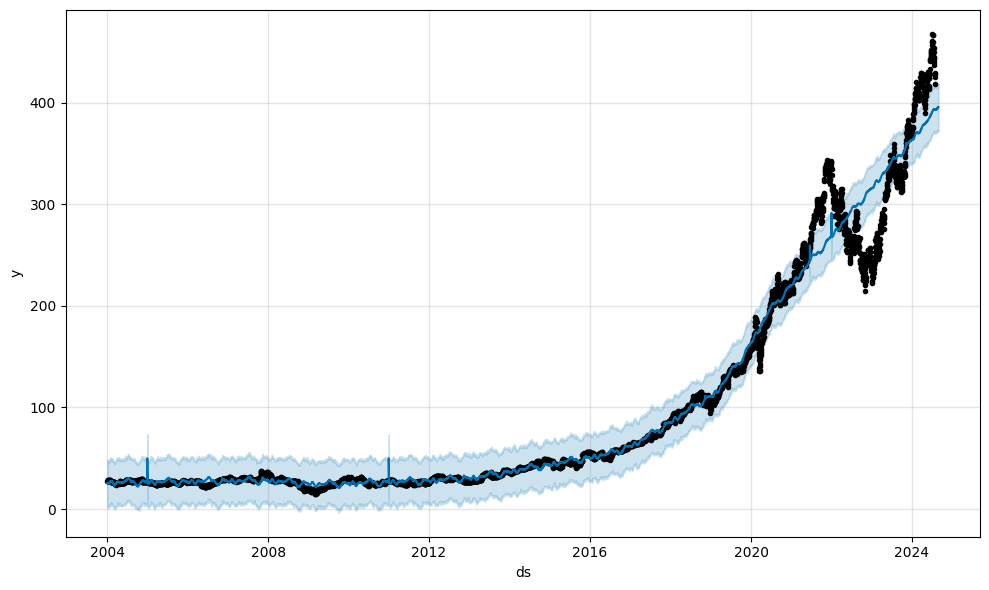

In [18]:
prophet_model.plot(forcast);

If you want to visualize the individual forecast components, we can use Prophet’s built-in plot_components method like below

c:\Users\ashok\Desktop\SPPO\.venv\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\ashok\Desktop\SPPO\.venv\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\ashok\Desktop\SPPO\.venv\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain

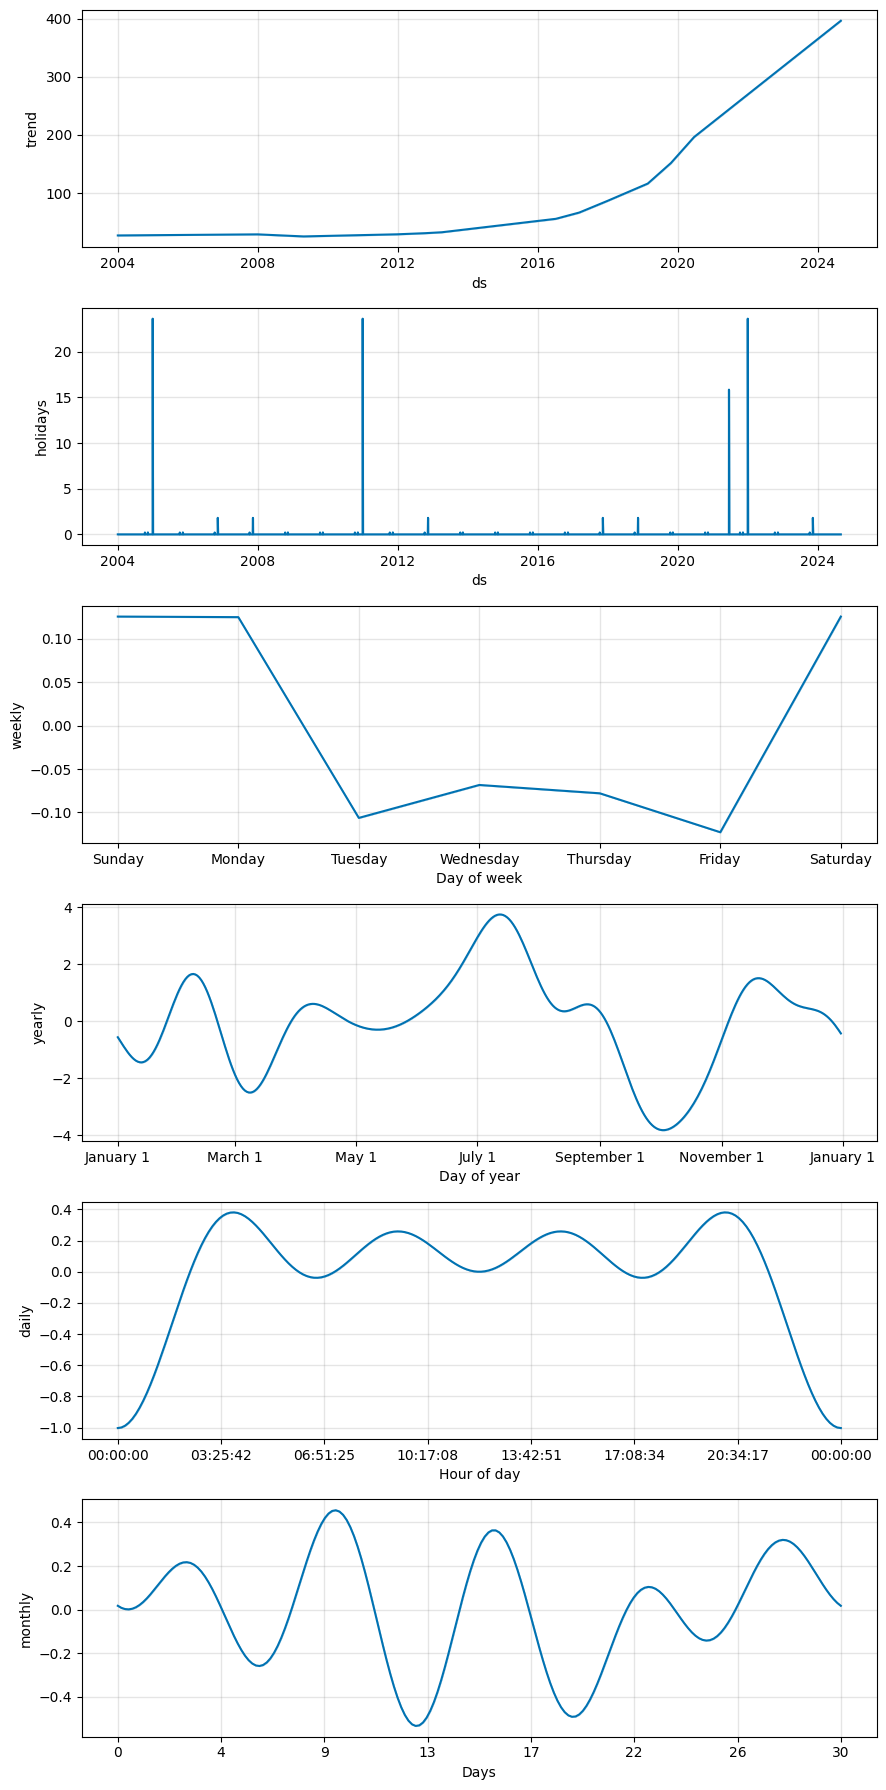

In [19]:
prophet_model.plot_components(forcast);

In [20]:
forcast.shape

(5207, 76)

In [21]:
forcast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5202,2024-08-24,395.724390,371.563332,417.975885
5203,2024-08-25,395.512144,373.261125,417.494850
5204,2024-08-26,395.293366,372.125533,418.532448
5205,2024-08-27,395.106586,371.991614,416.243604
5206,2024-08-28,395.459884,373.696300,418.296522


### Prediction Performance

The performance_metrics utility can be used to compute some useful statistics of the prediction performance (yhat, yhat_lower, and yhat_upper compared to y), as a function of the distance from the cutoff (how far into the future the prediction was). The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), and coverage of the yhat_lower and yhat_upper estimates. 

In [22]:
from prophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(prophet_model, horizon='180 days')
df_cv.head()

  0%|          | 0/76 [00:00<?, ?it/s]22:17:38 - cmdstanpy - INFO - Chain [1] start processing
22:17:38 - cmdstanpy - INFO - Chain [1] done processing
  1%|▏         | 1/76 [00:00<00:33,  2.23it/s]22:17:38 - cmdstanpy - INFO - Chain [1] start processing
22:17:38 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 2/76 [00:00<00:34,  2.16it/s]22:17:39 - cmdstanpy - INFO - Chain [1] start processing
22:17:39 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 3/76 [00:01<00:31,  2.31it/s]22:17:39 - cmdstanpy - INFO - Chain [1] start processing
22:17:39 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 4/76 [00:01<00:31,  2.27it/s]22:17:39 - cmdstanpy - INFO - Chain [1] start processing
22:17:40 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 5/76 [00:02<00:33,  2.12it/s]22:17:40 - cmdstanpy - INFO - Chain [1] start processing
22:17:40 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 6/76 [00:02<00:37,  1.85it/s]22:17:41

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2005-08-09,25.661012,25.129104,26.223653,27.350000,2005-08-08
1,2005-08-10,25.541959,24.942983,26.118410,26.950001,2005-08-08
2,2005-08-11,25.401256,24.816799,25.995423,27.270000,2005-08-08
3,2005-08-12,25.305875,24.734103,25.916621,27.049999,2005-08-08
4,2005-08-15,24.962521,24.351010,25.528364,27.129999,2005-08-08


In [23]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2005-08-09,25.661012,25.129104,26.223653,27.350000,2005-08-08
1,2005-08-10,25.541959,24.942983,26.118410,26.950001,2005-08-08
2,2005-08-11,25.401256,24.816799,25.995423,27.270000,2005-08-08
3,2005-08-12,25.305875,24.734103,25.916621,27.049999,2005-08-08
4,2005-08-15,24.962521,24.351010,25.528364,27.129999,2005-08-08
...,...,...,...,...,...,...
9419,2024-07-23,370.551689,350.441465,390.697388,444.850006,2024-01-31
9420,2024-07-24,370.990982,351.020118,391.237828,428.899994,2024-01-31
9421,2024-07-25,370.853955,350.281845,391.549769,418.399994,2024-01-31
9422,2024-07-26,370.380593,349.969443,391.338296,425.269989,2024-01-31


In [24]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,18 days,386.910253,19.670034,10.399952,0.095850,0.080204,0.096497,0.260185
1,19 days,375.630518,19.381190,10.278494,0.096187,0.080368,0.097049,0.260626
2,20 days,369.528894,19.223134,10.279813,0.096515,0.081859,0.097441,0.262821
3,21 days,373.989086,19.338797,10.338288,0.096752,0.082160,0.097566,0.262473
4,22 days,385.562984,19.635758,10.515143,0.097748,0.083261,0.098354,0.258021


In [25]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,18 days,386.910253,19.670034,10.399952,0.095850,0.080204,0.096497,0.260185
1,19 days,375.630518,19.381190,10.278494,0.096187,0.080368,0.097049,0.260626
2,20 days,369.528894,19.223134,10.279813,0.096515,0.081859,0.097441,0.262821
3,21 days,373.989086,19.338797,10.338288,0.096752,0.082160,0.097566,0.262473
4,22 days,385.562984,19.635758,10.515143,0.097748,0.083261,0.098354,0.258021
...,...,...,...,...,...,...,...,...
158,176 days,909.175416,30.152536,17.927549,0.178558,0.154047,0.184738,0.199870
159,177 days,910.573773,30.175715,17.914449,0.179179,0.154047,0.185408,0.200964
160,178 days,900.310205,30.005170,17.867004,0.179338,0.155228,0.186444,0.203156
161,179 days,864.728447,29.406265,17.599112,0.178616,0.154010,0.186738,0.206598


c:\Users\ashok\Desktop\SPPO\.venv\Lib\site-packages\prophet\plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\ashok\Desktop\SPPO\.venv\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


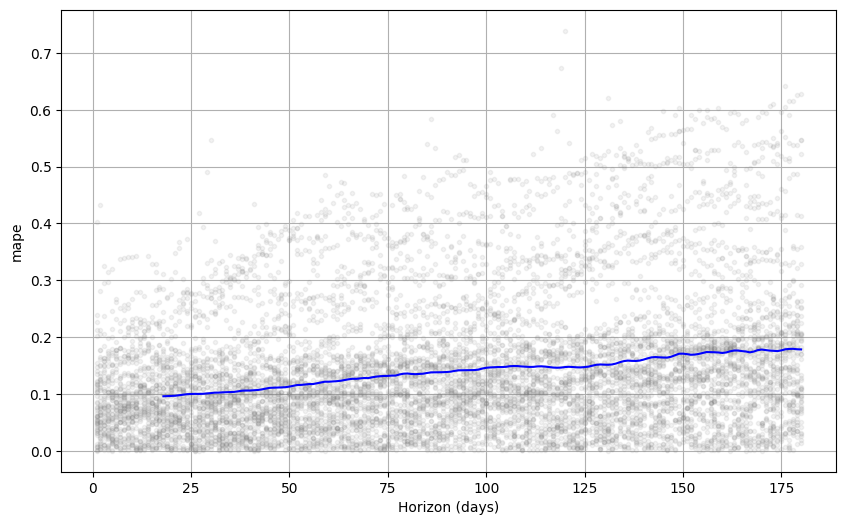

In [26]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')